# 2. Generic programming: Random walks

We want to think about an infection propagating through space as people move around and interact with each other. Probably the simplest way to model spatial motion is using **random walks**: at each time step, each person jumps in a random direction. This could take place in 1D (1 dimension) or 2D. For simplicity we will allow only integers.


Thinking initially about one single walker (person), how could we **simulate** this in the computer? We will run an **algorithm** that looks like:

0. Initialise the walker


1. At each step:
    - move the walker
    - store the current position


2. Repeat from step 1

Ideally we would write our code in such a way that it has this structure but is agnostic (unaware) of *which type of walker* is moving (1D, 2D, on a network, etc.).
This is called **generic programming**.

## Coding it up

Each step roughly corresponds to a different function. Each different type of walker will need a different way to `initialize()` itself.  `move()` will return the new position chosen by the walker.

The functions will need information about the walker, namely its current position.
Here is a fleshed-out version:

In [4]:
"Simulate a walk for `T` steps."
function walk(T)
    pos = initialize()
    
    trajectory = [pos]    # make a Vector that contains just the current value of `pos`
    
    for t in 1:T
        new_pos = move(pos)
        push!(trajectory, new_pos)   # append to the Vector
        
        pos = new_pos     # update for next iteration
    end
    
    return trajectory
end

walk

In [2]:
?walk

search: walk walkdir showable iswritable



Simulate a walk for `T` steps.


In [5]:
walk(100)

UndefVarError: UndefVarError: initialize not defined

Note that there's no problem to define this function, even though the `initialize` and `move` don't exist yet.

Let's think about a random walker moving in 1D. It starts at the origin (0) and jumps left or right with equal probability at each step:

In [34]:
# 1D walker

initialize() = 0

random_jump() = rand( (-1, +1) )

move(x) = x + random_jump()

move (generic function with 1 method)

In [30]:
rand( [-1, +1, 5] )

1

In [31]:
rand( (-1, +1, 5) )

-1

Benchmark: `BenchmarkTools.jl` package

In [8]:
initialize

initialize (generic function with 1 method)

In [9]:
initialize()

0

In [35]:
move(0)

1

In [36]:
move(1)

2

It is idiomatic (i.e. regarded as good programming style) in Julia to define tiny functions like this that do one little thing.
Note that *there is no cost* to doing so: Julia will *inline* such functions, removing the function-call overhead that you might have in other languages.

Having defined these functions, we can make a walk:

In [38]:
walk(100)'

1×101 LinearAlgebra.Adjoint{Int64,Array{Int64,1}}:
 0  1  2  3  4  3  2  1  2  1  0  -1  …  1  2  1  0  -1  -2  -3  -4  -5  -6

In [ ]:
walk(100)'   # "'" means "transpose"; this is just to save space

In [39]:
using Plots

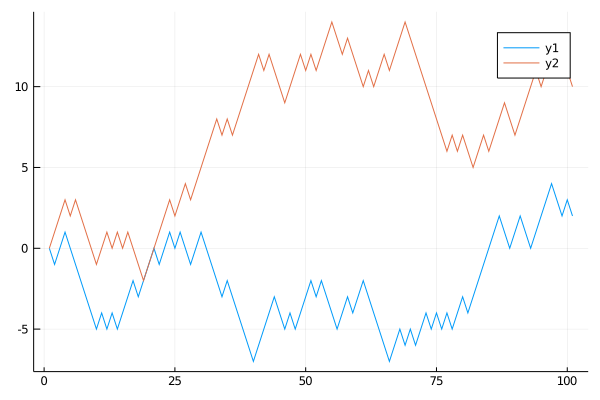

In [41]:
plot(walk(100))
plot!(walk(100))

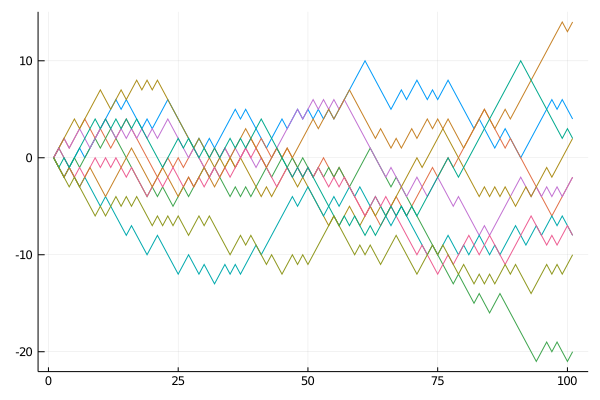

In [44]:
p = plot(legend=false)  # turn off the legend/key

for i in 1:10
    plot!(walk(100))  # plot! adds to the existing plot (modify existing plot)end
end

plot!()
# p

In [45]:
plotlyjs()

ArgumentError: ArgumentError: Package PlotlyJS not found in current path:
- Run `import Pkg; Pkg.add("PlotlyJS")` to install the PlotlyJS package.


## Generic programming

But now how could we do a 2D walker?
We hard-coded the function names inside `walk`, so we would have to redefine the functions using the same name.
But if we do so, they would *overwrite* (replace) the 1D version, which would thus no longer be usable.

Let's write versions of the functions for the 2D walker, e.g. using `Vector`s:

In [46]:
initialize_2D() = [0, 0]

move_2D(x) = [ x[1] + random_jump(), x[2] + random_jump() ]  # x is a vector

move_2D (generic function with 1 method)

(Note that we could write

In [ ]:
move_2D(x) = [ move(x[1]), move(x[2]) ] 

)

In [47]:
initialize_2D()

2-element Array{Int64,1}:
 0
 0

In [48]:
move_2D([0, 0])

2-element Array{Int64,1}:
 -1
  1

Note: For short vectors of fixed length like this, you should use `SVector`s from the [`StaticArrays.jl`](https://github.com/JuliaArrays/StaticArrays.jl) package to get much better performance. Exercise!

How can we use these new functions, which have the *wrong name*, inside our `walk` function?

The key **idea** is that we want to call these new functions when `initialize` and `move` are called inside `walk`.
To do so we can *pass these functions as arguments* to `walk`!:

In [51]:
function walk(initialize, move, T)
    pos = initialize()
    
    trajectory = [pos]
    
    for t in 1:T
        pos = move(pos)               # *update* the value pointed to by `pos`
        push!(trajectory, deepcopy(pos))  # at the cost of needing to copy `pos` when we store it if it is a vector
    end
    
    return trajectory
end

walk (generic function with 2 methods)

In [50]:
methods(walk)

# 2 methods for generic function "walk":
[1] walk(T) in Main at In[4]:3
[2] walk(initialize, move, T) in Main at In[49]:2

Julia informs us that there are now 2 **methods** (versions) of the `walk` function:

In [ ]:
methods(walk)

Passing in the 2D functions behaves as we hoped and gives us a 2D walk!:

In [53]:
trajectory = walk(initialize_2D, move_2D, 10)

11-element Array{Array{Int64,1},1}:
 [0, 0]
 [1, -1]
 [2, 0]
 [1, -1]
 [2, -2]
 [3, -1]
 [2, -2]
 [3, -1]
 [2, -2]
 [3, -1]
 [2, -2]

In [54]:
trajectory[1]

2-element Array{Int64,1}:
 0
 0

Why is `copy` necessary inside `walk`? It's because of how Julia thinks of variables. A variable is a name that "points to" an object. Suppose I do the following:

In [ ]:
a = [1, 2]
v = [a]

In [ ]:
a[1] = 5

In [ ]:
push!(v, a)

You can see that we end up with two copies of the *same* object, instead of the original value and the modified value. This is because the mutable objects stored inside `v` are really just the *names* of the same object.

In [55]:
trajectory = walk(initialize_2D, move_2D, 10)

11-element Array{Array{Int64,1},1}:
 [0, 0]
 [-1, 1]
 [-2, 2]
 [-3, 3]
 [-4, 4]
 [-3, 3]
 [-4, 2]
 [-3, 1]
 [-2, 2]
 [-3, 3]
 [-2, 2]

In [57]:
w1 = initialize()
w2 = initialize(2)

MethodError: MethodError: no method matching initialize(::Int64)
Closest candidates are:
  initialize() at In[34]:3

## Two walkers

#### Exercise: 

1. Suppose there are two walkers in 1D, one of which starts at position 0 and the other of which starts at position 2. How long does it take for them to meet each other, i.e. to land on the same location? Write a function `encounter` that runs *until* they meet each other. 


2. Run this function many times and accumulate the resulting times in a vector.


3. Plot the histogram of the result. How does it behave?


4. How do these results change if the walkers live inside a box, e.g. from -20 to 20. At the ends of the box if they try to jump outside the box they "bounce back" and stay at the same location.

In [58]:
initialize(x) = x

initialize (generic function with 2 methods)

In [59]:
w1 = initialize()
w2 = initialize(2)

2

At each step:

In [60]:
w1 = move(w1)
w2 = move(w2)

3

Now compare their positions to see if they have met yet.

### Counting when a walker passes through a point

w = 3

How many times does w pass through the origin up to some final time?

Now suppose we would like a random walker to have some "knowledge", for example, we want it to keep track of how many times it has passed through the origin. This is data that we somehow want to "associate to" the walker, which will need to be stored in a variable somewhere. The walker should be able to "remember" and modify this information. 

In our above formulation it is not clear how to do this. We need to set up this variable to contain the initial position in the `initialize` function, and then update it in the `move` function, so this data needs to be shared between these two functions.

There are two common ways to deal with this:

- **Global variables**, which live outside any function and are updated inside each function. However, this means that the functions can no longer be understood just by looking at their definition, and it allows outside influences to modify the data.

    > Global variables make bad code that is hard to read and understand. Avoid them!

- **Pass the data as an additional parameter** to each function. Unfortunately this will require modifying the surrounding code where the functions are called.

An apparent partial solution to this is to use a **`let` block**. This is a technique that allows us to create a new **scope** and a local variable that exists only inside that scope:

In [ ]:
let x=0 
    
    global init(s) = x = s   # this looks strange, but the first `=` defines the function
                             # the second `=` is in the body of the function
    
    global move() = x += 1
    
    global current() = x
    
end

In [ ]:
init(3)

In [ ]:
move()

In [ ]:
move()

In [ ]:
current()

In [ ]:
init(3)

In [ ]:
move()

In [ ]:
x   # doesn't exist here: it exists only inside the let block

This seems like a great solution! That is, until you ask the question "how can I make a second, independent walker?". You can't, since as soon as you call `initialize()` again, you reset the value of `x`.

Then you would probably start thinking about an array where you store the position of each walker, which is certainly doable.
But probably you are starting to get the feeling that there should be a better solution, where we can make different walkers and refer to them individually.